## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, Nadam
from keras import regularizers

classpath = os.path.abspath('..')
if classpath not in sys.path: sys.path.insert(0, classpath)

from solution import telecom_functions as fn

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    
def draw_roc_curve(y, pred):
    from matplotlib import pyplot as plt

    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()

Requirement already up-to-date: seaborn in d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages (0.9.0)


Using TensorFlow backend.


## Data Schema

Column name         | Description
				 ---|---
customerIDCustomer 	|	ID
genderCustomer  	|	gender (female, male)
SeniorCitizen    	|	Whether the customer is a senior citizen or not (1, 0)
Partner    			|	Whether the customer has a partner or not (Yes, No)
Dependents    		|	Whether the customer has dependents or not (Yes, No)
tenure				|	Number of months the customer has stayed with the company
PhoneService    	|	Whether the customer has a phone service or not (Yes, No)
MultipleLines    	|	Whether the customer has multiple lines or not (Yes, No, No phone service)
InternetService		|	Customer’s internet service provider (DSL, Fiber optic, No)
OnlineSecurity    	|	Whether the customer has online security or not (Yes, No, No internet service)
OnlineBackup    	|	Whether the customer has online backup or not (Yes, No, No internet service)
DeviceProtection   	|	Whether the customer has device protection or not (Yes, No, No internet service)
TechSupport    		|	Whether the customer has tech support or not (Yes, No, No internet service)
StreamingTV    		|	Whether the customer has streaming TV or not (Yes, No, No internet service)
StreamingMovies    	|	Whether the customer has streaming movies or not (Yes, No, No internet service)
contract 			|	The contract term of the customer (Month-to-month, One year, Two year)
PaperlessBilling    |	Whether the customer has paperless billing or not (Yes, No)
PaymentMethod		|	The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges		|	The amount charged to the customer monthly
TotalCharges		|	The total amount charged to the customer
churned				|	Whether the customer churned or not (Yes or No)

---

* 16個類別變數(customer id 不算)
* 3個numeric變數


---
<br/>
<br/>
<br/>

# Purpose: 
* 給定客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?

In [2]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_telco_customer_churn.csv")
raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_telco_customer_churn.csv")
raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Drop 不必要的欄位

In [3]:
raw.drop(['customerID'], 1, inplace=True)
raw_vl.drop(['customerID'], 1, inplace=True)

## Data Clean: TotalCharges

* 讀取進來的時候因為有空字串, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing
* Tansfer `Churn` [Yes, No] to [1, 0]

In [4]:
# TotalCharges 讀取進來的時候因為有missing value, 導致於變成字串type, 需要轉型為float, 並且做missing value imputing
def str2num(e):
    try:
        return float(e)
    except:
        return np.nan
              
tmp = raw.TotalCharges.map(str2num)
raw['TotalCharges'] = tmp.fillna(tmp.median())
raw['Churn'] = raw.Churn.map(lambda e: 1 if e == 'Yes' else 0)

tmp = raw_vl.TotalCharges.map(str2num)
raw_vl['TotalCharges'] = tmp.fillna(tmp.median())
raw_vl['Churn'] = raw_vl.Churn.map(lambda e: 1 if e == 'Yes' else 0)
del tmp

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 20 columns):
gender              5634 non-null object
SeniorCitizen       5634 non-null int64
Partner             5634 non-null object
Dependents          5634 non-null object
tenure              5634 non-null int64
PhoneService        5634 non-null object
MultipleLines       5634 non-null object
InternetService     5634 non-null object
OnlineSecurity      5634 non-null object
OnlineBackup        5634 non-null object
DeviceProtection    5634 non-null object
TechSupport         5634 non-null object
StreamingTV         5634 non-null object
StreamingMovies     5634 non-null object
Contract            5634 non-null object
PaperlessBilling    5634 non-null object
PaymentMethod       5634 non-null object
MonthlyCharges      5634 non-null float64
TotalCharges        5634 non-null float64
Churn               5634 non-null int64
dtypes: float64(2), int64(3), object(15)
memory usage: 880.4+ KB


## Features setting

In [6]:
catg_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PhoneService', 'MultipleLines', 'InternetService',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
# embedding_features = catg_features + ['binn_tenure', 'binn_MonthlyCharges', 'binn_TotalCharges']
label = 'Churn'

<br/>

---



## Base Feature Preprocessing

* Normalize ofr numeric features
* One Hot Encoding for categorical features

In [7]:
def feature_engineering(raw, is_train=True, status=None):
    data = raw.copy()
    
    if is_train:
        status = {'scaler': None, 
                  'mapper': defaultdict(LabelBinarizer),
                  'woe_mapper': {},
                  'binn_mapper': {},
                  'freq_mapper': {},
                  'mean_mapper': {}}

    catg_ftrs = catg_features.copy()
        
    # Numeric binning to categorical features
    do_binning(catg_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    catg_part = pd.DataFrame()
    
    # One Hot Encoding
    # catg_part = pd.get_dummies(data[catg_ftrs])
    do_onehot(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Embedding, simple indexing categorical features, actual embedding function in keras
    # do_embedding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # WOE encoding
    do_woe_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Frequency encoding, target mean encoding
    do_target_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Normalize
    num_part = do_norm(num_features, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # Merge categorical, numeric features
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Churn'].copy()
    
    # Include quadratic term, cube term
    do_nth_order_polynominal(num_features, data_x)
    # ----------------------------------------------------------------------------------------- 
    return data_x, data_y, status


# # import fe_functions as fn
# do_onehot = fn.do_onehot
# do_norm = fn.do_norm
# do_embedding = fn.do_embedding
# do_binning = fn.do_binning
# do_woe_encoding = fn.do_woe_encoding
# do_target_encoding = fn.do_target_encoding
# do_nth_order_polynominal = fn.do_nth_order_polynominal

## Functions of Features Processing

In [39]:
def do_binning(catg_ftrs, status, data, is_train):
    pass

def do_onehot(catg_ftrs, catg_part, status, data, is_train):
    mapper = status['mapper']
    tmp = []
    for catg_col in catg_ftrs:
        if is_train:
            result = mapper[catg_col].fit_transform(data[catg_col])
        else:
            result = mapper[catg_col].transform(data[catg_col])

        columns = [f'{catg_col}_{col}' for col in mapper[catg_col].classes_]
        if result.shape[1] == 1:
            columns = columns[:1]
        tmp.append(pd.DataFrame(data=result, columns=columns))
    tmp = pd.concat(tmp, 1)
    for col in tmp:
        catg_part[col] = tmp[col]
    pass

def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):
    pass

def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
    pass

def do_norm(num_features, status, data, is_train):
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        status['scaler'] = scaler
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        scaler = status['scaler']
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    return num_part
    pass

def do_nth_order_polynominal(num_features, data):
    pass

## Model on Base Featue Engineering

* Network Structure: 
    * `dimension of input, 32, 16, 16, 1`
* ReLU Activation Function
* Adam Optimizer
* Sigmoid Cross Entropy

In [38]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # def metrics_auc(y_true, y_pred):
    #     auc, _ = K.metrics.auc(y_true, y_pred)
    #     return K.mean(auc, axis=-1)
    # model.compile(optimizer='sgd', loss = 'binary_crossentropy', metrics = [metrics_auc])
    return model

In [40]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 40) (1409, 40)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,-1.273098,-1.155973,-0.990447
1,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0.072520,-0.253553,-0.166213
2,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,-1.232322,-0.356781,-0.955743
3,1,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0.521060,-0.741392,-0.187820
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,-1.232322,0.204318,-0.936463


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 1s 120us/step - loss: 0.6795 - acc: 0.7236 - val_loss: 0.6647 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 34us/step - loss: 0.6561 - ac

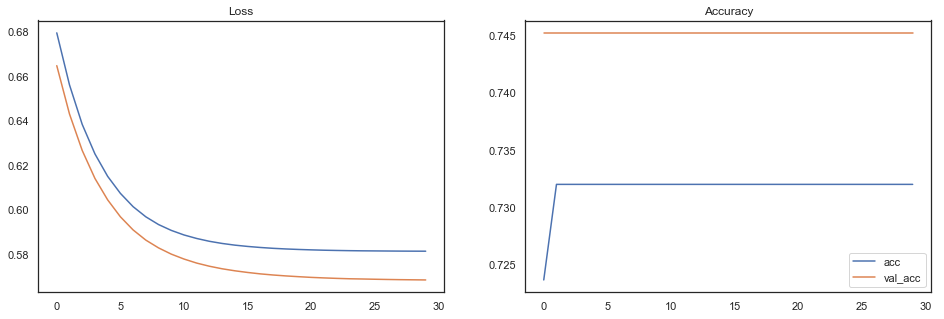

auc: 0.7594614670380686


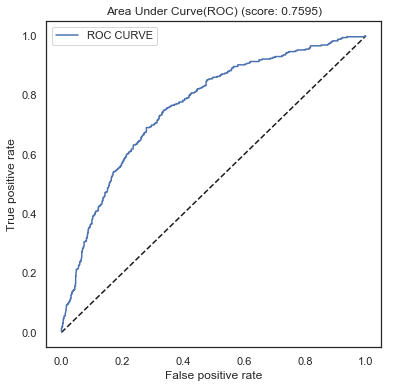

In [41]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## Analyze the Prediction

In [42]:
y_pred = model.predict(vl_x)
y_pred

array([[0.27372226],
       [0.27364352],
       [0.27369058],
       ...,
       [0.2737606 ],
       [0.27385095],
       [0.27370417]], dtype=float32)

count    1409.000000
mean        0.273694
std         0.000074
min         0.273516
25%         0.273638
50%         0.273694
75%         0.273756
max         0.273865
dtype: float64
0.2736936 7.434905e-05


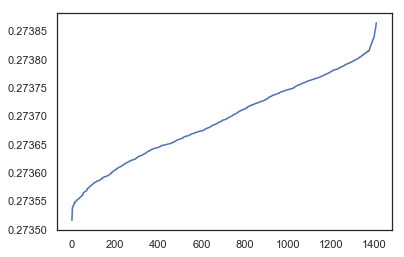

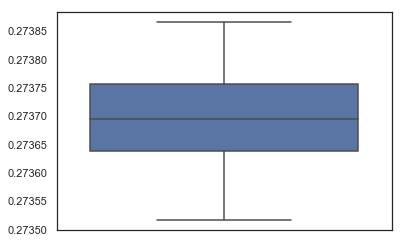

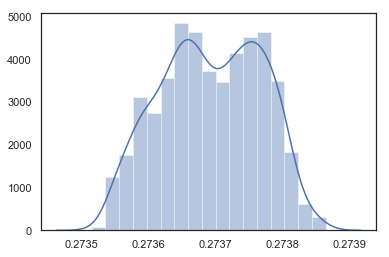

In [43]:
def pred_dist(y_pred):
    y_pred = pd.Series(y_pred.ravel())
    print( y_pred.describe() )
    print( y_pred.mean(), y_pred.std() )
    sns.lineplot(range(len(y_pred)), sorted(y_pred.ravel()))
    plt.show()

    sns.boxplot(y_pred.ravel(), orient='v')
    plt.show()

    sns.distplot(y_pred.ravel())
    plt.show()
    
pred_dist(y_pred)

## Observation

* 預測機率範圍集中在 `0.273`左右, 已經是小數點3位以下的差距
* Accuracy預設threshold = 0.5, model不會產出Positive的預測
* 問題變成找出最佳Threshold ==> 預測機率大於多少時認為是`Churn = 1`

---


## 找出最佳閥值

In [44]:
# 依照所有的閥值(切割100等分)算出F score, 找出分數最高的閥值
def f_beta_scann(y_true, y_pred, beta=0.5):
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1] 
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]

def analyze(y_true, y_pred):
    thres, f_beta = f_beta_scann(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))
    
analyze(vl_y, y_pred)

thres: 0.2738, f_beta score: 0.5229
accuracy@0.2738: 0.76

threshold@0.5, accuracy: 0.7452
[[1050    0]
 [ 359    0]] 

threshold@0.2738, accuracy: 0.7551
[[870 180]
 [165 194]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Observation

* 整體Accuracy 0.75, 卻無法產出 `Churn = 1` 的預測
* 經果F beta score掃描之後, 整體Accuracy 降低, 但能夠產出退租名單
* 根據以上, 是否還會糾結於 Accuracy 的高低?

## Bining Numeric Feature

* Quartile cut


In [47]:
def do_binning(catg_ftrs, status, data, is_train):
    # Quartile binning, outlier set to class "0"
    def quartile_binning(x):
        bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
        iqr_x_150 = (bins[-1] - bins[0]) * 1.5
        bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
        result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
        return result, bins

    for col in ('tenure', 'MonthlyCharges', 'TotalCharges'):
        binned_name = f'binn_{col}'
        if is_train:
            result, bins = quartile_binning(data[col])
            status['binn_mapper'][binned_name] = bins
            data[binned_name] = result
        else:
            bins = status['binn_mapper'][binned_name]
            data[binned_name] = pd.Series(np.digitize(data[col], bins))\
                                  .map(pd.Series([0, 1, 2, 3, 4, 0])).values

        catg_ftrs.append(binned_name)
    pass

In [46]:
def do_binning(catg_ftrs, status, data, is_train): pass

In [48]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 52) (1409, 52)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,binn_MonthlyCharges_2,binn_MonthlyCharges_3,binn_MonthlyCharges_4,binn_TotalCharges_1,binn_TotalCharges_2,binn_TotalCharges_3,binn_TotalCharges_4,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,-1.273098,-1.155973,-0.990447
1,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0.072520,-0.253553,-0.166213
2,1,0,0,0,0,0,1,0,0,1,...,1,0,0,1,0,0,0,-1.232322,-0.356781,-0.955743
3,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0.521060,-0.741392,-0.187820
4,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,-1.232322,0.204318,-0.936463


## Model (Binning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3392      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 1s 132us/step - loss: 0.6793 - acc: 0.7307 - val_loss: 0.6645 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 34us/step - loss: 0.6559 - ac

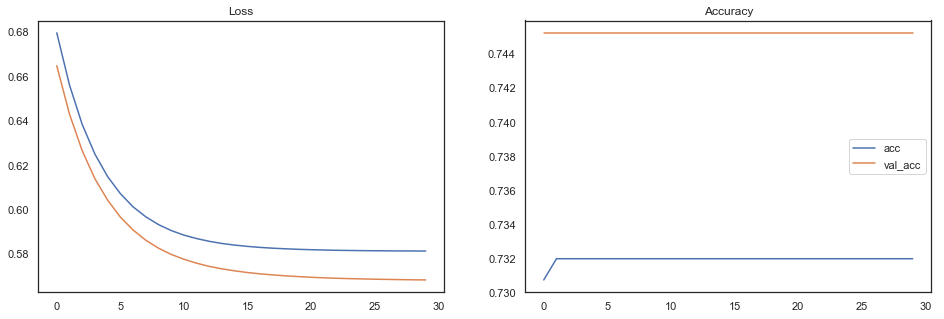

auc: 0.7594097360392625


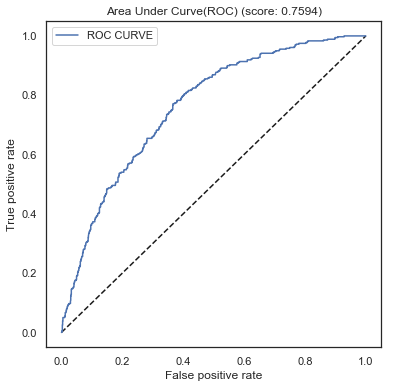

count    1409.000000
mean        0.272577
std         0.000120
min         0.272286
25%         0.272485
50%         0.272589
75%         0.272680
max         0.272814
dtype: float64
0.27257746 0.00011970373


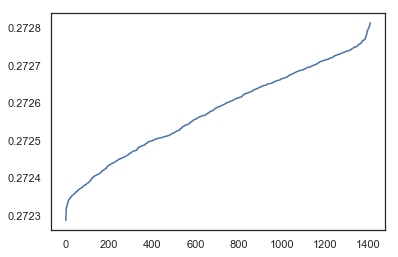

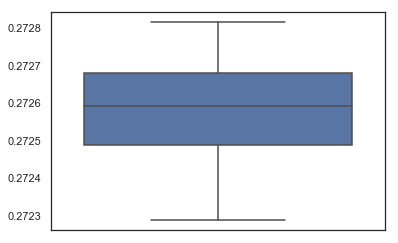

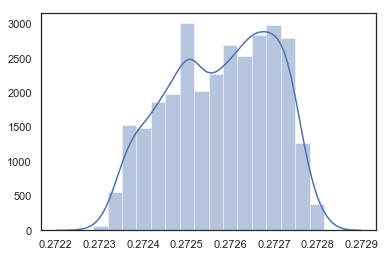

thres: 0.2727, f_beta score: 0.5129
accuracy@0.2727: 0.76

threshold@0.5, accuracy: 0.7452
[[1050    0]
 [ 359    0]] 

threshold@0.2727, accuracy: 0.7559
[[894 156]
 [188 171]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Add Weight of Evidence Encoding

In [50]:
def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):

    def woe_encode(x, label, data):
        """Calculate the Weight of Evidence of given categorical feature and label

        :param x: Given feature name
        :param label: Label name
        :param data:
        :return: WOE encoded dictionary
        """
        total_vc = data[label].value_counts().sort_index()

        def woe(pipe, total_vc):
            # Count by label in this group
            group_vc = pipe[label].value_counts().sort_index()

            # Some class in the feature is missing, fill zero to missing class
            if len(group_vc) < len(total_vc):
                for key in total_vc.index:
                    if key not in group_vc:
                        group_vc[key] = 0.
                group_vc = group_vc.sort_index()

            # WOE formula
            r = ((group_vc + 0.5) / total_vc).values

            # Odd ratio => 1 to 0, you can define meaning of each class
            return np.log(r[1] / r[0])

        return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))

    for catg_col in catg_ftrs:
        if is_train:
            kv = woe_encode(catg_col, 'Churn', data)
            status['woe_mapper'][catg_col] = kv.to_dict()
        else:
            kv = pd.Series(status['woe_mapper'][catg_col])
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    pass

In [51]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 71) (1409, 71)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,woe_InternetService,woe_Contract,woe_PaperlessBilling,woe_PaymentMethod,woe_binn_tenure,woe_binn_MonthlyCharges,woe_binn_TotalCharges,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,...,-0.445889,0.738504,0.337875,0.855740,1.070782,-1.039678,0.763840,-1.273098,-1.155973,-0.990447
1,1,0,0,0,0,0,1,1,0,0,...,-0.445889,-1.104910,-0.608877,-0.420783,-0.420389,-0.153503,-0.214491,0.072520,-0.253553,-0.166213
2,1,0,0,0,0,0,1,0,0,1,...,-0.445889,0.738504,0.337875,-0.420783,1.070782,-0.153503,0.763840,-1.232322,-0.356781,-0.955743
3,1,0,0,0,0,0,1,1,0,0,...,-0.445889,-1.104910,-0.608877,-0.606650,-0.420389,-0.153503,-0.214491,0.521060,-0.741392,-0.187820
4,0,0,0,0,1,0,0,1,0,0,...,0.714524,0.738504,0.337875,0.855740,1.070782,0.532289,0.763840,-1.232322,0.204318,-0.936463


## Model (WOE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 7,233
Trainable params: 7,233
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 1s 126us/step - loss: 0.6795 - acc: 0.7268 - val_loss: 0.6647 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 36us/step - loss: 0.6560 - ac

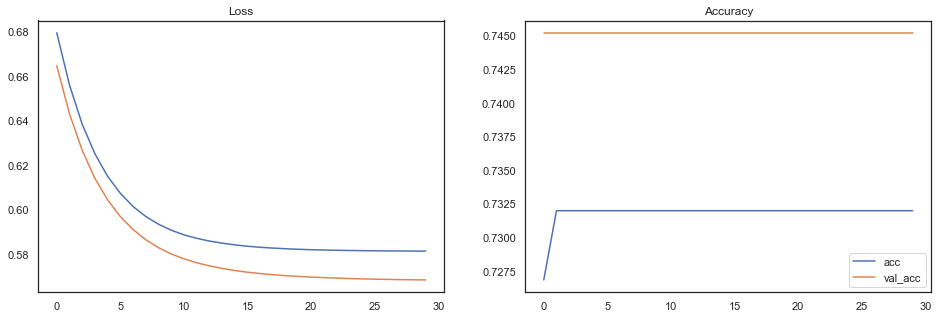

auc: 0.7622801432550735


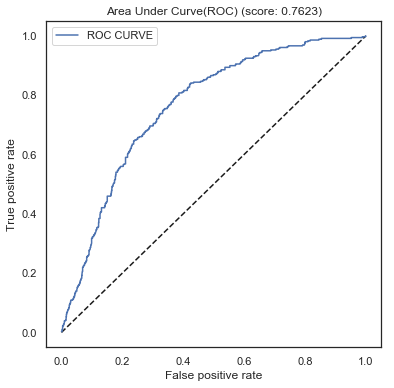

count    1409.000000
mean        0.272868
std         0.000082
min         0.272639
25%         0.272814
50%         0.272881
75%         0.272936
max         0.273050
dtype: float64
0.27286768 8.150727e-05


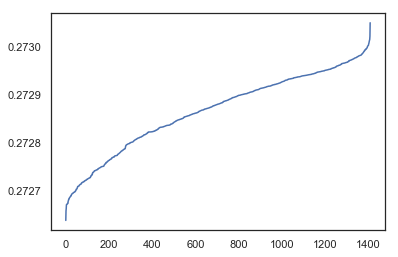

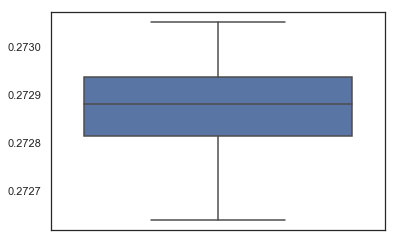

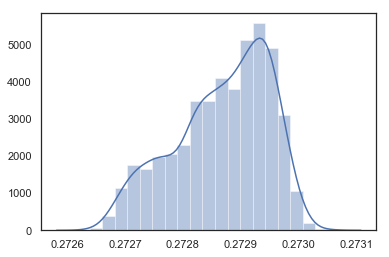

thres: 0.2729, f_beta score: 0.5106
accuracy@0.2729: 0.75

threshold@0.5, accuracy: 0.7452
[[1050    0]
 [ 359    0]] 

threshold@0.2729, accuracy: 0.7459
[[853 197]
 [161 198]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Statistical Encoding, Target Encoding

* Frequency encoding
* Mean encoding

In [53]:
def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
    for catg_col in catg_ftrs:
        if is_train:
            freq_proportion = data[catg_col].value_counts() / len(data)
            catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
            target_mean = data.groupby(catg_col).Churn.mean()
            catg_part[f'mean_{catg_col}'] = target_mean.reindex(data[catg_col]).values

            status['freq_mapper'][catg_col] = freq_proportion.to_dict()
            status['mean_mapper'][catg_col] = target_mean.to_dict()
        else:
            catg_part[f'freq_{catg_col}'] = pd.Series(status['freq_mapper'][catg_col]).reindex(data[catg_col]).values
            catg_part[f'mean_{catg_col}'] = pd.Series(status['mean_mapper'][catg_col]).reindex(data[catg_col]).values
    pass

In [54]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 109) (1409, 109)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,mean_PaymentMethod,freq_binn_tenure,mean_binn_tenure,freq_binn_MonthlyCharges,mean_binn_MonthlyCharges,freq_binn_TotalCharges,mean_binn_TotalCharges,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,...,0.462806,0.247071,0.516523,0.249911,0.114347,0.250089,0.440028,-1.273098,-1.155973,-0.990447
1,1,0,0,0,0,0,1,1,0,0,...,0.193572,0.245651,0.193642,0.249734,0.238806,0.250799,0.227884,0.072520,-0.253553,-0.166213
2,1,0,0,0,0,0,1,0,0,1,...,0.193572,0.247071,0.516523,0.249734,0.238806,0.250089,0.440028,-1.232322,-0.356781,-0.955743
3,1,0,0,0,0,0,1,1,0,0,...,0.166132,0.245651,0.193642,0.249734,0.238806,0.250799,0.227884,0.521060,-0.741392,-0.187820
4,0,0,0,0,1,0,0,1,0,0,...,0.462806,0.247071,0.516523,0.250089,0.383960,0.250089,0.440028,-1.232322,0.204318,-0.936463


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7040      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 0s 83us/step - loss: 0.6795 - acc: 0.7261 - val_loss: 0.6647 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 35us/step - loss: 0.6561 - acc

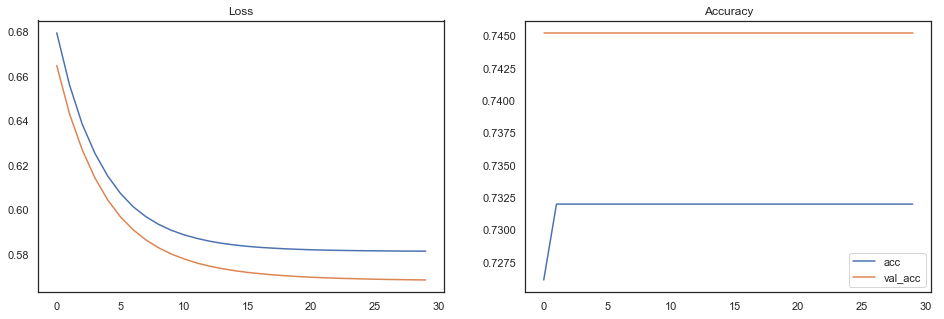

auc: 0.7336012733784321


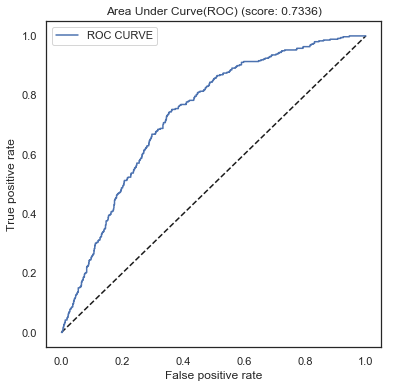

count    1409.000000
mean        0.273210
std         0.000156
min         0.272828
25%         0.273098
50%         0.273250
75%         0.273343
max         0.273462
dtype: float64
0.27321044 0.00015626052


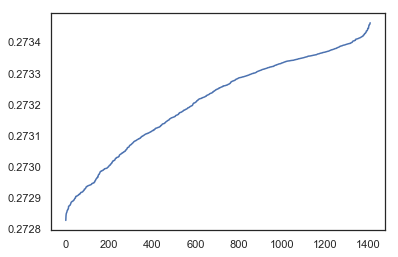

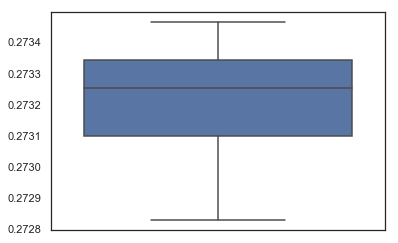

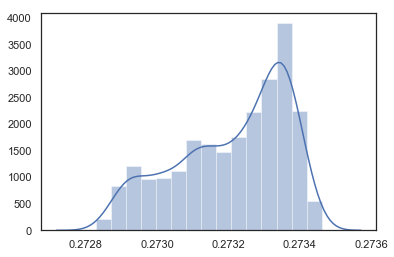

thres: 0.2733, f_beta score: 0.4649
accuracy@0.2733: 0.72

threshold@0.5, accuracy: 0.7452
[[1050    0]
 [ 359    0]] 

threshold@0.2733, accuracy: 0.7189
[[829 221]
 [175 184]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [56]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Add Polynomial Featue Engineering

* Add quradratic, cube term base on numeric features

In [57]:
def do_nth_order_polynominal(num_features, data):
    for num_col in num_features:
        data[f'{num_col}_degree_2'] = data[num_col] ** 2
        data[f'{num_col}_degree_3'] = data[num_col] ** 3
    pass

In [58]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 115) (1409, 115)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,mean_binn_TotalCharges,tenure,MonthlyCharges,TotalCharges,tenure_degree_2,tenure_degree_3,MonthlyCharges_degree_2,MonthlyCharges_degree_3,TotalCharges_degree_2,TotalCharges_degree_3
0,0,0,1,0,1,0,0,0,0,1,...,0.440028,-1.273098,-1.155973,-0.990447,1.620779,-2.063410,1.336273,-1.544696,0.980985,-0.971613
1,1,0,0,0,0,0,1,1,0,0,...,0.227884,0.072520,-0.253553,-0.166213,0.005259,0.000381,0.064289,-0.016301,0.027627,-0.004592
2,1,0,0,0,0,0,1,0,0,1,...,0.440028,-1.232322,-0.356781,-0.955743,1.518617,-1.871424,0.127293,-0.045416,0.913444,-0.873018
3,1,0,0,0,0,0,1,1,0,0,...,0.227884,0.521060,-0.741392,-0.187820,0.271503,0.141469,0.549663,-0.407516,0.035276,-0.006626
4,0,0,0,0,1,0,0,1,0,0,...,0.440028,-1.232322,0.204318,-0.936463,1.518617,-1.871424,0.041746,0.008529,0.876962,-0.821242


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding + Polynominal)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7424      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 0s 83us/step - loss: 0.6794 - acc: 0.7318 - val_loss: 0.6643 - val_acc: 0.7452
Epoch 2/30
5634/5634 [==============================] - 0s 35us/step - loss: 0.6557 - a

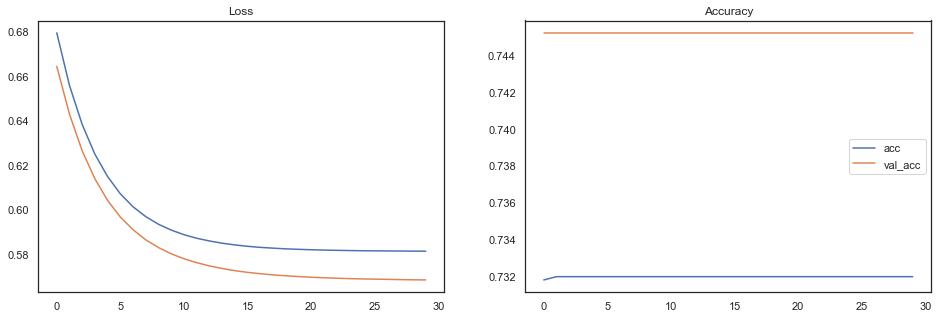

auc: 0.7615108104523147


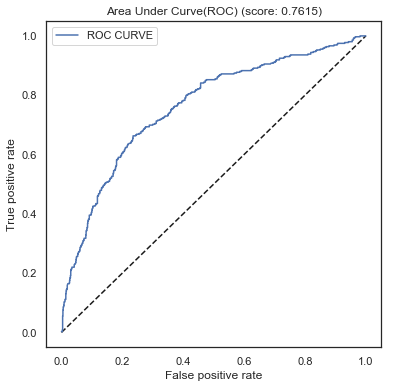

count    1409.000000
mean        0.273319
std         0.000223
min         0.272309
25%         0.273242
50%         0.273365
75%         0.273478
max         0.273638
dtype: float64
0.27331904 0.000223241


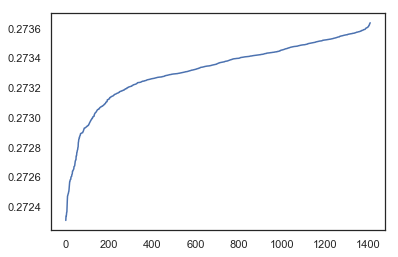

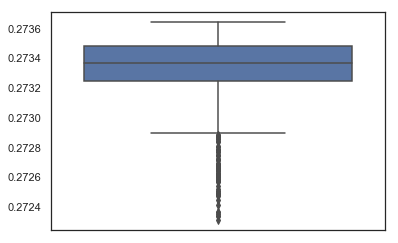

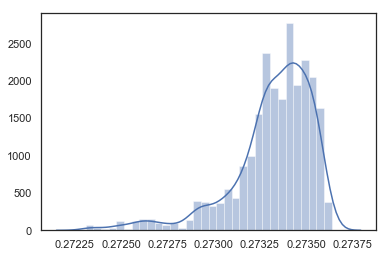

thres: 0.2735, f_beta score: 0.5422
accuracy@0.2735: 0.78

threshold@0.5, accuracy: 0.7452
[[1050    0]
 [ 359    0]] 

threshold@0.2735, accuracy: 0.7757
[[940 110]
 [206 153]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## PCA

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
tr_x_pca = pca.fit_transform(tr_x)
vl_x_pca = pca.transform(vl_x)

In [29]:
tr_x_pca.shape, vl_x_pca.shape

((5634, 64), (1409, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 0s 88us/step - loss: 0.4600 - acc: 0.7741 - val_loss: 0.4343 - val_acc: 0.7871
Epoch 2/30
5634/5634 [==============================] - 0s 42us/step - loss: 0.4083 - acc

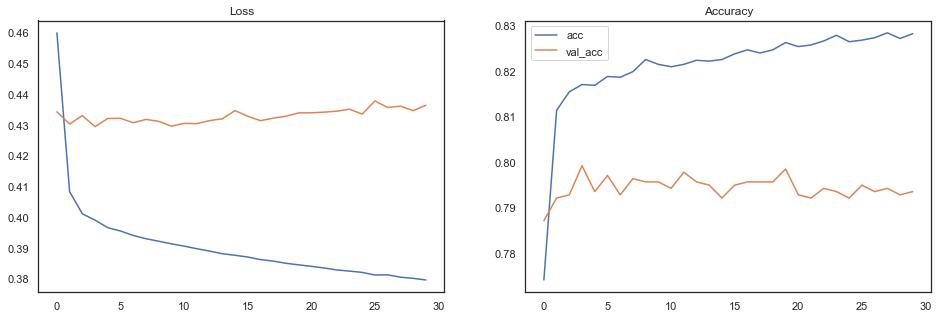

auc: 0.8272940708316753


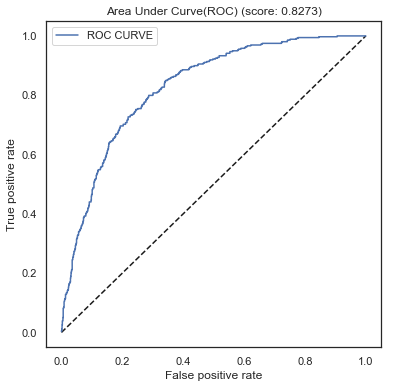

count    1409.000000
mean        0.269307
std         0.265477
min         0.000998
25%         0.035489
50%         0.181414
75%         0.445390
max         0.918706
dtype: float64
0.26930708 0.26547673


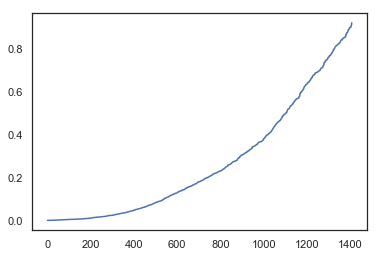

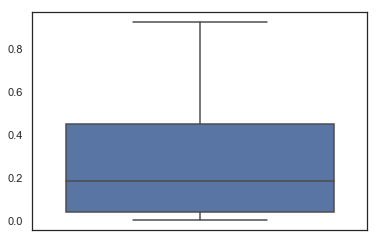

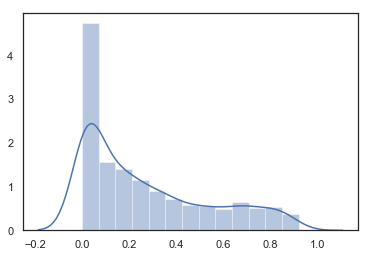

thres: 0.4830, f_beta score: 0.5950
accuracy@0.4830: 0.79

threshold@0.5, accuracy: 0.7935
[[932 118]
 [173 186]] 

threshold@0.4830, accuracy: 0.7949
[[924 126]
 [163 196]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
K.clear_session()

model = get_model(input_dim=tr_x_pca.shape[1])
hist = model.fit(tr_x_pca, tr_y, validation_data=(vl_x_pca, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_pca))

y_pred = model.predict(vl_x_pca)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Model (AutoEncoder)

In [33]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(5634, 115) (1409, 115)


,gender_Female,SeniorCitizen_0,Partner_No,Dependents_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,...,mean_binn_TotalCharges,tenure,MonthlyCharges,TotalCharges,tenure_degree_2,tenure_degree_3,MonthlyCharges_degree_2,MonthlyCharges_degree_3,TotalCharges_degree_2,TotalCharges_degree_3
0,0,0,1,0,1,0,0,0,0,1,...,0.440028,-1.273098,-1.155973,-0.990447,1.620779,-2.063410,1.336273,-1.544696,0.980985,-0.971613
1,1,0,0,0,0,0,1,1,0,0,...,0.227884,0.072520,-0.253553,-0.166213,0.005259,0.000381,0.064289,-0.016301,0.027627,-0.004592
2,1,0,0,0,0,0,1,0,0,1,...,0.440028,-1.232322,-0.356781,-0.955743,1.518617,-1.871424,0.127293,-0.045416,0.913444,-0.873018
3,1,0,0,0,0,0,1,1,0,0,...,0.227884,0.521060,-0.741392,-0.187820,0.271503,0.141469,0.549663,-0.407516,0.035276,-0.006626
4,0,0,0,0,1,0,0,1,0,0,...,0.440028,-1.232322,0.204318,-0.936463,1.518617,-1.871424,0.041746,0.008529,0.876962,-0.821242


Train on 5634 samples, validate on 1409 samples
Epoch 1/100
5634/5634 [==============================] - 1s 171us/step - loss: 0.3979 - val_loss: 0.1318
Epoch 2/100
5634/5634 [==============================] - 0s 30us/step - loss: 0.0977 - val_loss: 0.0764
Epoch 3/100
5634/5634 [==============================] - 0s 30us/step - loss: 0.0675 - val_loss: 0.0600
Epoch 4/100
5634/5634 [==============================] - 0s 33us/step - loss: 0.0545 - val_loss: 0.0491
Epoch 5/100
5634/5634 [==============================] - 0s 36us/step - loss: 0.0448 - val_loss: 0.0408
Epoch 6/100
5634/5634 [==============================] - 0s 33us/step - loss: 0.0374 - val_loss: 0.0341
Epoch 7/100
5634/5634 [==============================] - 0s 33us/step - loss: 0.0317 - val_loss: 0.0290
Epoch 8/100
5634/5634 [==============================] - 0s 34us/step - loss: 0.0272 - val_loss: 0.0252
Epoch 9/100
5634/5634 [==============================] - 0s 35us/step - loss: 0.0236 - val_loss: 0.0220
Epoch 10/100
56

5634/5634 [==============================] - 0s 35us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 79/100
5634/5634 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 80/100
5634/5634 [==============================] - 0s 30us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 81/100
5634/5634 [==============================] - 0s 35us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 82/100
5634/5634 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 83/100
5634/5634 [==============================] - 0s 30us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 84/100
5634/5634 [==============================] - 0s 30us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 85/100
5634/5634 [==============================] - 0s 36us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 86/100
5634/5634 [==============================] - 0s 32us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 87/100
5634/5634 [==============================] - 0s 37us/st

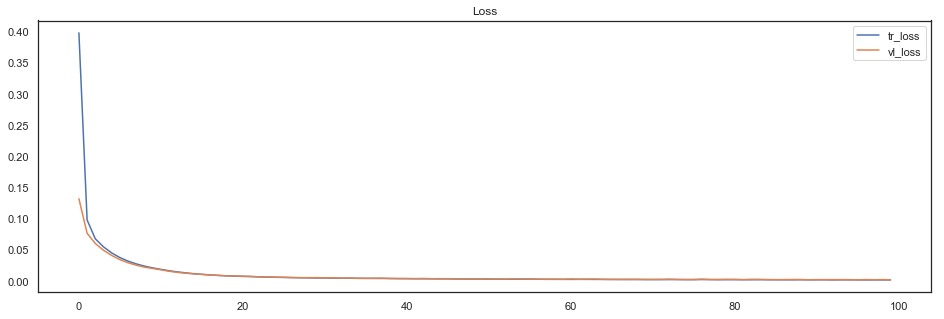

In [34]:
K.clear_session()

inputs_dim = tr_x.shape[1]

inputs = Input(shape=(inputs_dim, ))
# Encoder
encoded = Dense(inputs_dim, activation='selu')(inputs)
encoded = Dense(128, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)

# Decoder
decoded = Dense(64, activation='selu')(encoded)
decoded = Dense(64, activation='selu')(decoded)
decoded = Dense(128, activation='selu')(decoded)
decoded = Dense(inputs_dim, activation='linear')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs, decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs, encoded)

# Adam Optimizer + Mean square error loss
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
    tr_x, tr_x, 
    epochs=100, 
    batch_size=200, 
    shuffle=True, 
    validation_data=(vl_x, vl_x))

def plot_ae(hist):
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')
    plt.legend(loc='best')
    plt.show()
    
plot_ae(hist)

In [35]:
tr_x_ae = encoder.predict(tr_x)
vl_x_ae = encoder.predict(vl_x)

In [36]:
tr_x_ae.shape, vl_x_ae.shape

((5634, 64), (1409, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
Train on 5634 samples, validate on 1409 samples
Epoch 1/30
5634/5634 [==============================] - 0s 88us/step - loss: 0.4811 - acc: 0.7519 - val_loss: 0.4451 - val_acc: 0.7850
Epoch 2/30
5634/5634 [==============================] - 0s 39us/step - loss: 0.4335 - acc

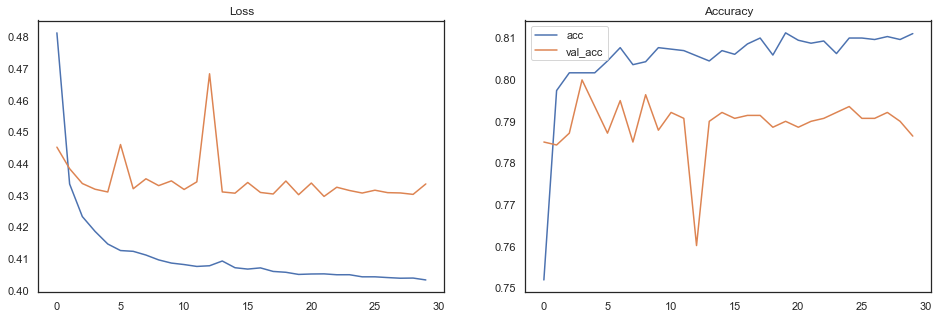

auc: 0.8285754078790292


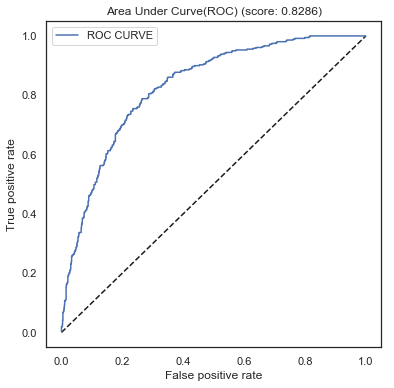

count    1409.000000
mean        0.287458
std         0.259177
min         0.005743
25%         0.045159
50%         0.225399
75%         0.492873
max         0.856229
dtype: float64
0.28745824 0.2591774


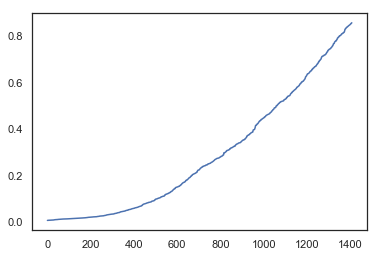

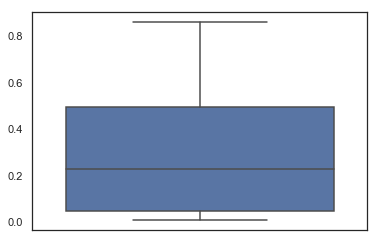

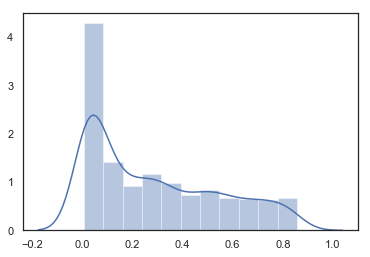

thres: 0.5126, f_beta score: 0.5914
accuracy@0.5126: 0.79

threshold@0.5, accuracy: 0.7864
[[906 144]
 [157 202]] 

threshold@0.5126, accuracy: 0.7928
[[917 133]
 [159 200]]


d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
K.clear_session()

model = get_model(input_dim=tr_x_ae.shape[1])
hist = model.fit(tr_x_ae, tr_y, validation_data=(vl_x_ae, vl_y), batch_size=100, epochs=30)

plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_ae))

y_pred = model.predict(vl_x_ae)
pred_dist(y_pred)
analyze(vl_y, y_pred)